In [ ]:
# parameters
# set a fscore threshold for filtering low quality concepts
fscore_threshold = 0.95

# folders of your cavs classifiers, key should be the number of motif insertions, value should be the folder containing classifier folders
cavs_folders = {
    12: "output/pipeline_test_5000_12_motifs_motif_only/cavs/",
    24: "output/pipeline_test_5000_24_motifs_motif_only/cavs/",
    36: "output/pipeline_test_5000_36_motifs_motif_only/cavs/"
}

In [ ]:
num_insertions = list(cavs_folders.keys())

In [3]:
import os, re
import torch
import pandas as pd
import seaborn as sns
from glob import glob
from functools import reduce
from scipy import stats
from sklearn.metrics import precision_recall_fscore_support as score

In [4]:
def load_cavs_from_folder(cavs_dir):
    all_perform_on_test_fns = glob(os.path.join(cavs_dir, "*/*perform_on_test.txt"))

    df = []
    for fn in all_perform_on_test_fns:
        concept, _ = os.path.relpath(fn, cavs_dir).split("/")
        concept = re.split(r'_control_', concept)[0]

        # compute fscore on test dataset
        performance = pd.read_table(fn, comment="#")
        precision, recall, fscore, support = score(performance.Truth, performance.Pred)
        
        df.append((concept, fscore.mean().item()))
    return pd.DataFrame(df, columns=['concept', 'fscore'])

In [7]:
concept_fscore_tables = []
for key, folder in cavs_folders.items():
    concept_fscore_table = load_cavs_from_folder(folder).rename(columns={'fscore': int(key)})
    concept_fscore_tables.append(concept_fscore_table)

In [8]:
concept_fscore_tables

[                                concept        12
 0                 AC0001:GATA-PROP:GATA  0.462226
 1           AC0002:PROP-ALX:Homeodomain  0.631410
 2        AC0003:HNF1A-HNF1B:Homeodomain  0.725731
 3                  AC0004:ZSCAN:C2H2_ZF  0.904799
 4    AC0005:POU3F-POU1F:Homeodomain,POU  0.648016
 ..                                  ...       ...
 632           AC0633:TBX-MGA::EVX:T-box  0.593544
 633                  AC0634:ZNF:C2H2_ZF  0.467501
 634              AC0635:TBX-EOMES:T-box  0.583873
 635                   AC0636:SREBF:bHLH  0.558728
 636                     AC0637:AHR:bHLH  0.608945
 
 [637 rows x 2 columns],
                                 concept        24
 0                 AC0001:GATA-PROP:GATA  0.747827
 1           AC0002:PROP-ALX:Homeodomain  0.882589
 2        AC0003:HNF1A-HNF1B:Homeodomain  0.947691
 3                  AC0004:ZSCAN:C2H2_ZF  0.984007
 4    AC0005:POU3F-POU1F:Homeodomain,POU  0.908629
 ..                                  ...       ...
 632

In [9]:
def reduce_tables(left, right):
    return pd.merge(left, right, on='concept', how='left')

merged_concepts_tables = reduce(reduce_tables, concept_fscore_tables)

In [10]:
merged_concepts_tables

,concept,12,24,36
0,AC0001:GATA-PROP:GATA,0.462226,0.747827,0.870802
1,AC0002:PROP-ALX:Homeodomain,0.631410,0.882589,0.960273
2,AC0003:HNF1A-HNF1B:Homeodomain,0.725731,0.947691,0.992772
3,AC0004:ZSCAN:C2H2_ZF,0.904799,0.984007,0.997898
4,"AC0005:POU3F-POU1F:Homeodomain,POU",0.648016,0.908629,0.980448
...,...,...,...,...
632,AC0633:TBX-MGA::EVX:T-box,0.593544,0.854638,0.946887
633,AC0634:ZNF:C2H2_ZF,0.467501,0.732609,0.899784
634,AC0635:TBX-EOMES:T-box,0.583873,0.840731,0.932412
635,AC0636:SREBF:bHLH,0.558728,0.826703,0.946743


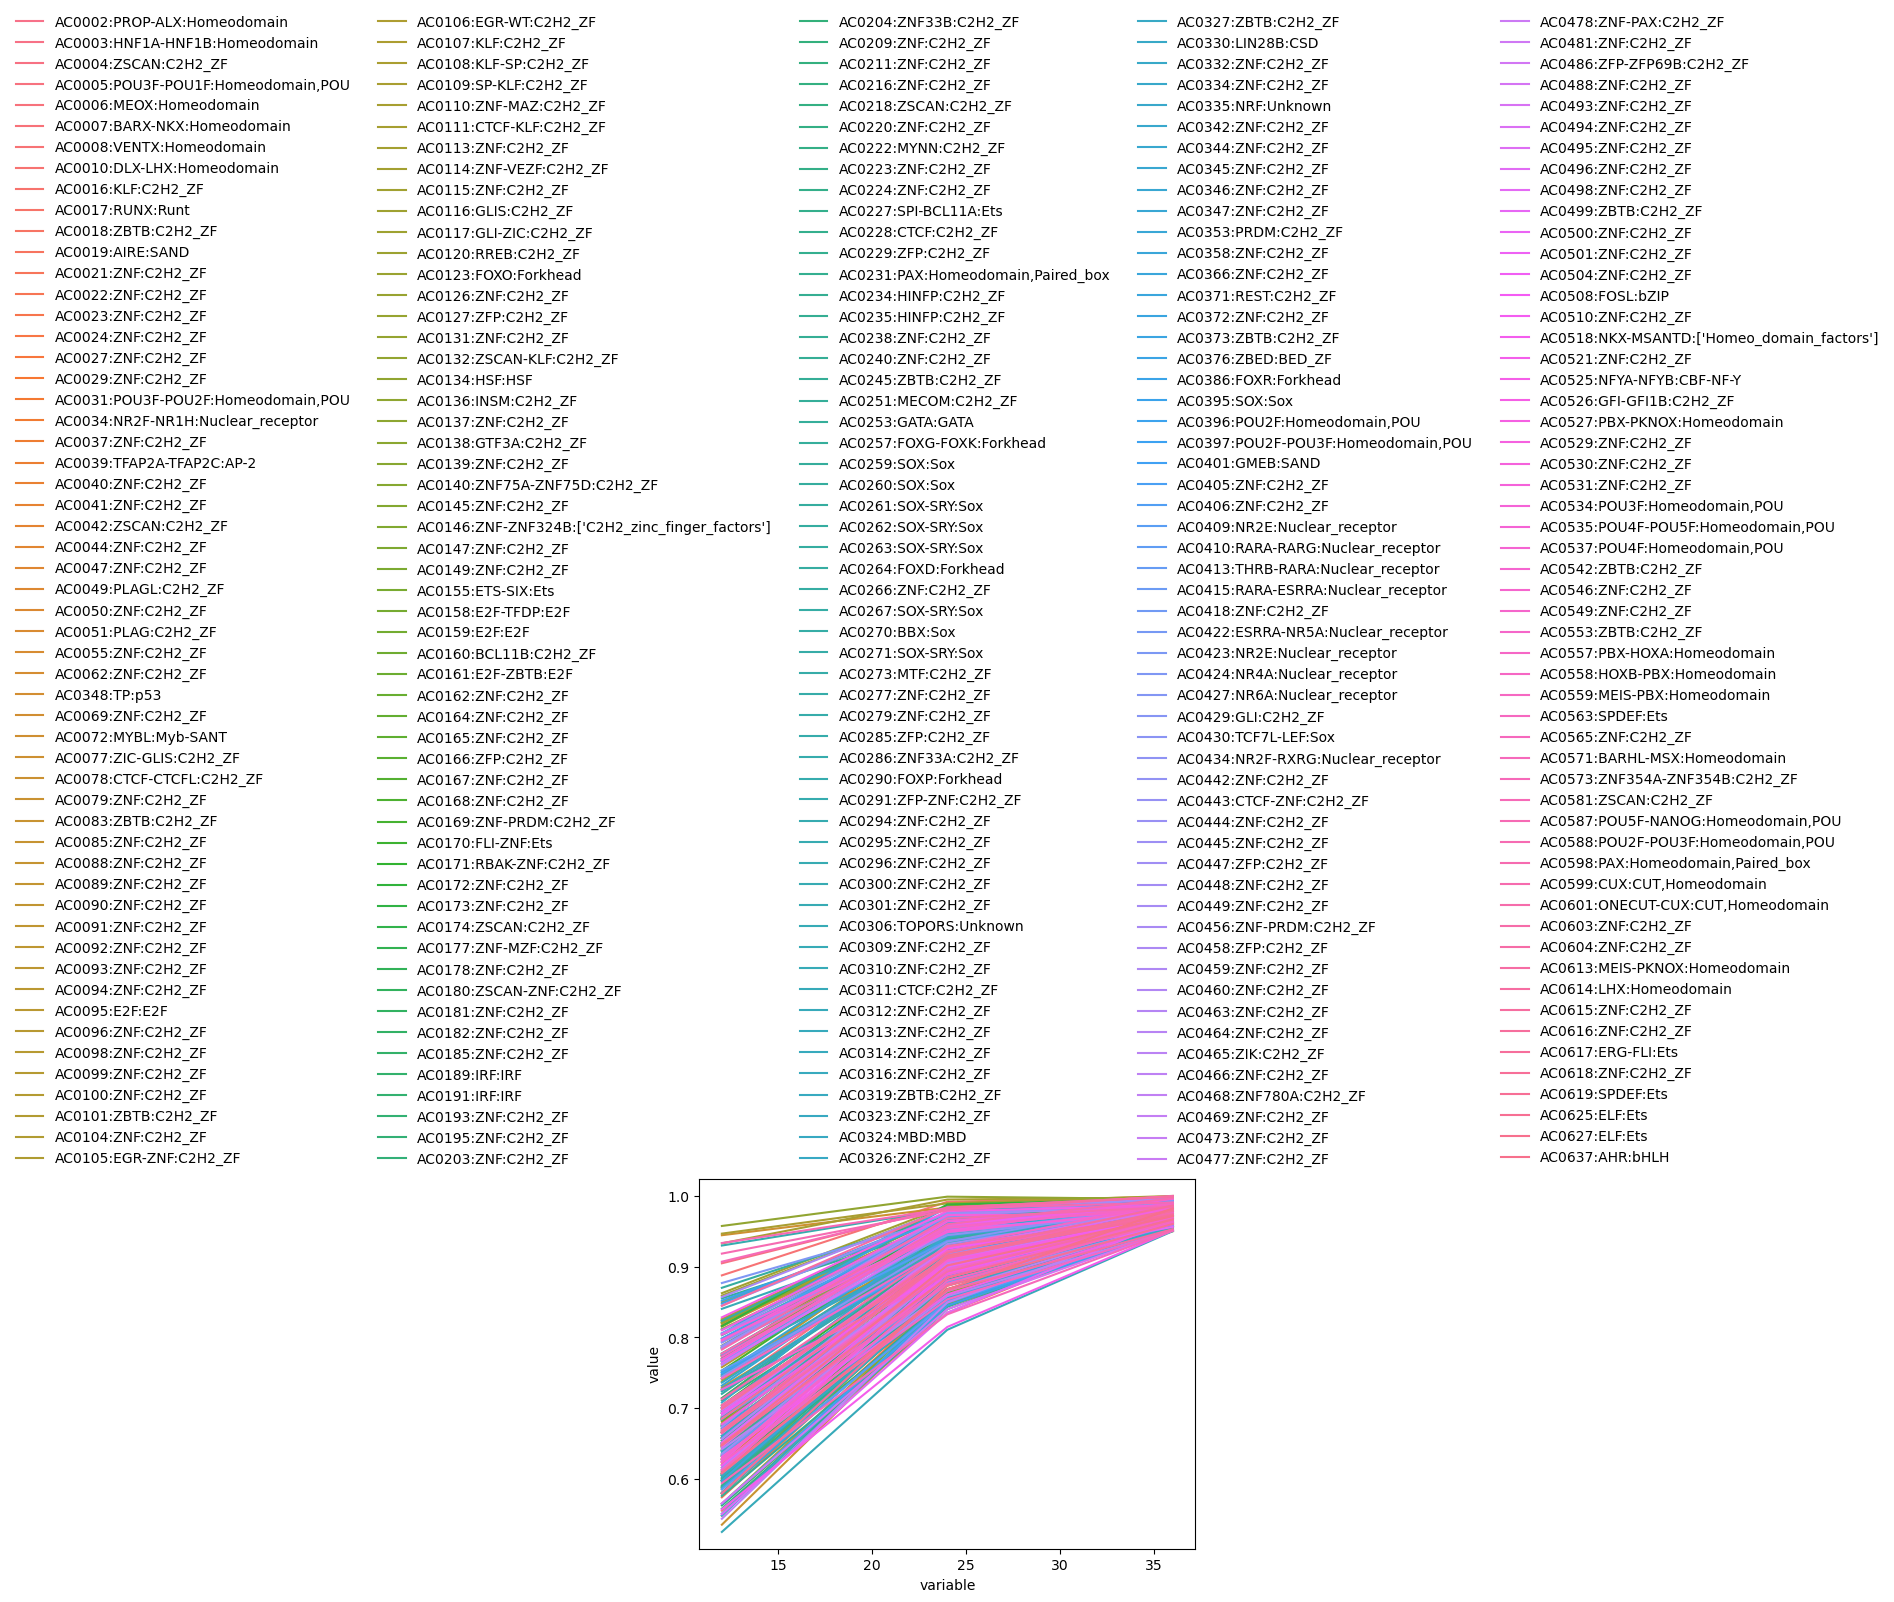

In [11]:
df_plot = merged_concepts_tables.loc[(merged_concepts_tables[num_insertions]>fscore_threshold).any(axis=1)]
df_plot = df_plot.melt(value_vars=num_insertions,
             id_vars='concept')
ax = sns.lineplot(data=df_plot, x='variable', y='value', hue='concept')
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=False,
)

In [12]:
merged_concepts_tables

,concept,12,24,36
0,AC0001:GATA-PROP:GATA,0.462226,0.747827,0.870802
1,AC0002:PROP-ALX:Homeodomain,0.631410,0.882589,0.960273
2,AC0003:HNF1A-HNF1B:Homeodomain,0.725731,0.947691,0.992772
3,AC0004:ZSCAN:C2H2_ZF,0.904799,0.984007,0.997898
4,"AC0005:POU3F-POU1F:Homeodomain,POU",0.648016,0.908629,0.980448
...,...,...,...,...
632,AC0633:TBX-MGA::EVX:T-box,0.593544,0.854638,0.946887
633,AC0634:ZNF:C2H2_ZF,0.467501,0.732609,0.899784
634,AC0635:TBX-EOMES:T-box,0.583873,0.840731,0.932412
635,AC0636:SREBF:bHLH,0.558728,0.826703,0.946743


In [13]:
def compute_linregress_slope(item):
    x = []; y = []
    for k, v in item.items():
        if k == 'concept':
            continue
        x.append(k)
        y.append(item[k])
    res = stats.linregress(x, y)
    return res.slope, res.rvalue**2
merged_concepts_tables[['slope', 'R^2']] = merged_concepts_tables.apply(compute_linregress_slope, axis=1, result_type='expand')

In [14]:
merged_concepts_tables

,concept,12,24,36,slope,R^2
0,AC0001:GATA-PROP:GATA,0.462226,0.747827,0.870802,0.017024,0.949839
1,AC0002:PROP-ALX:Homeodomain,0.631410,0.882589,0.960273,0.013703,0.915103
2,AC0003:HNF1A-HNF1B:Homeodomain,0.725731,0.947691,0.992772,0.011127,0.872414
3,AC0004:ZSCAN:C2H2_ZF,0.904799,0.984007,0.997898,0.003879,0.859054
4,"AC0005:POU3F-POU1F:Homeodomain,POU",0.648016,0.908629,0.980448,0.013851,0.902926
...,...,...,...,...,...,...
632,AC0633:TBX-MGA::EVX:T-box,0.593544,0.854638,0.946887,0.014723,0.929271
633,AC0634:ZNF:C2H2_ZF,0.467501,0.732609,0.899784,0.018012,0.983179
634,AC0635:TBX-EOMES:T-box,0.583873,0.840731,0.932412,0.014522,0.930351
635,AC0636:SREBF:bHLH,0.558728,0.826703,0.946743,0.016167,0.953786


<Axes: xlabel='slope', ylabel='Count'>

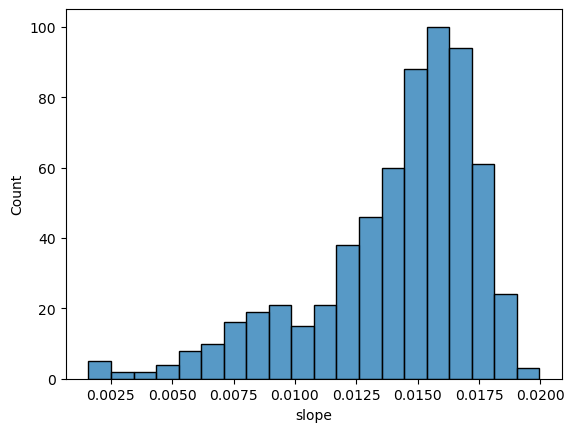

In [15]:
sns.histplot(data=merged_concepts_tables, x='slope')

In [16]:
merged_concepts_tables_sorted_by_slope = merged_concepts_tables.loc[((merged_concepts_tables[num_insertions]>fscore_threshold).any(axis=1))].sort_values('slope')

In [18]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(merged_concepts_tables_sorted_by_slope.reset_index(drop=True))

                                             concept        12        24  \
0                                     AC0134:HSF:HSF  0.957552  0.998949   
1                            AC0077:ZIC-GLIS:C2H2_ZF  0.944478  0.983656   
2                              AC0108:KLF-SP:C2H2_ZF  0.946736  0.989602   
3                               AC0290:FOXP:Forkhead  0.929897  0.981421   
4                 AC0587:POU5F-NANOG:Homeodomain,POU  0.933423  0.982020   
5                              AC0109:SP-KLF:C2H2_ZF  0.932978  0.994893   
6                 AC0588:POU2F-POU3F:Homeodomain,POU  0.918495  0.979441   
7                               AC0581:ZSCAN:C2H2_ZF  0.907063  0.983622   
8                               AC0004:ZSCAN:C2H2_ZF  0.904799  0.984007   
9                           AC0008:VENTX:Homeodomain  0.887748  0.991718   
10                                AC0262:SOX-SRY:Sox  0.870168  0.975153   
11                      AC0424:NR4A:Nuclear_receptor  0.876931  0.968783   
12          

In [19]:
# save top 30 concepts
#merged_concepts_tables_sorted_by_slope.iloc[:30].to_csv(f"output/top30_motifs_fscore{fscore_threshold}_slope.tsv", header=True, index=False, sep="\t")